Mean Squared Error Test: 0.00000000004095712083
R^2 Score Test: 0.99999870976160709635


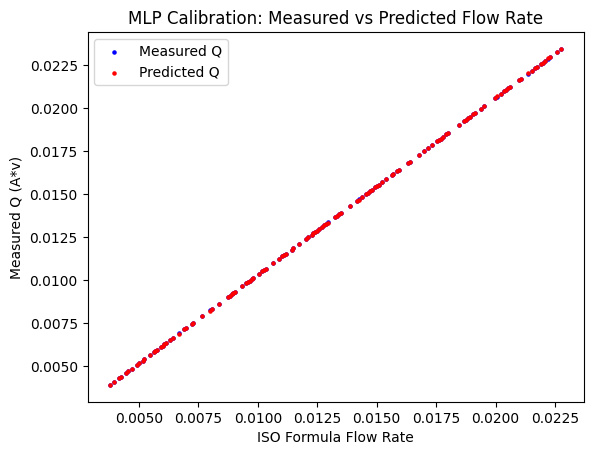

Mean Squared Error Train: 0.00000000004413271624
R^2 Score Train: 0.99999866147238514191


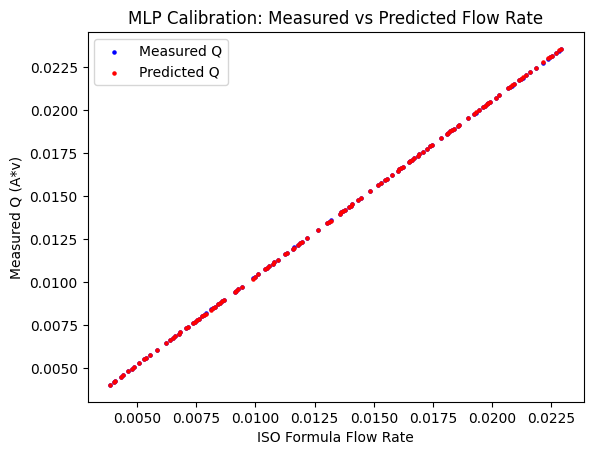

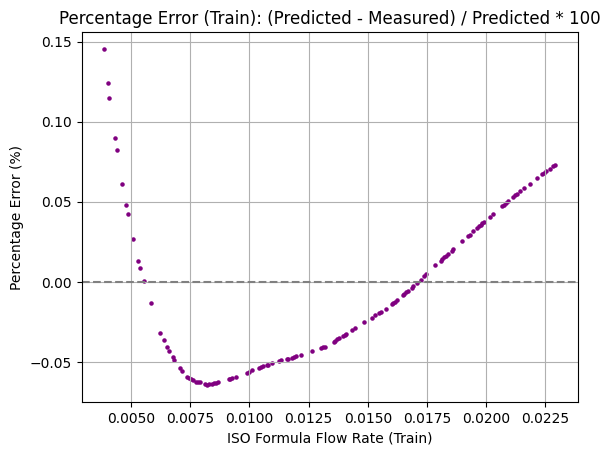

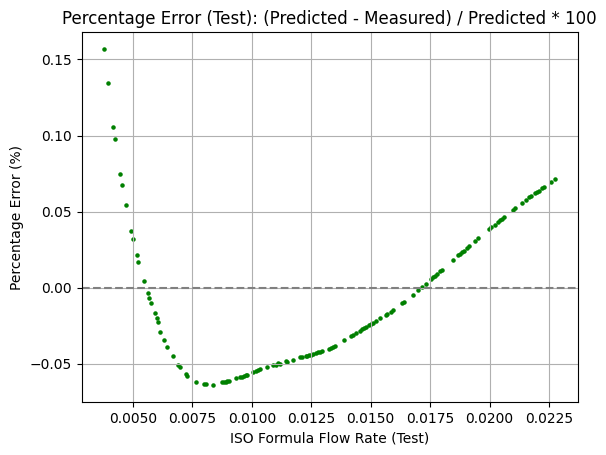

ISO Flow Rate: 0.004185585, Calibrated Q: 0.0043


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# Load the Excel file (replace 'your_data.xlsx' with your actual file path)
data = pd.read_excel('result_D100.xlsx')

# Assume columns are named 'ISO_Flow' for ISO formula results and 'Measured_Q' for measured flow rate
X = data[['Input (ISO)']].values  # Input: ISO formula results
y = data['Output (Q)'].values   # Output: Measured Q (A*v)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Standardize the input and output data (MLPs perform better with scaled data)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Initialize and train the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='identity', solver='adam', 
                   max_iter=1000, random_state=42, verbose=False)
mlp.fit(X_train_scaled, y_train_scaled)

# Predict on test set
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # Convert back to original scale

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error Test: {mse:.20f}")
print(f"R^2 Score Test: {r2:.20f}")

# Plot actual vs predicted values
plt.scatter(X_test, y_test, color='blue', s=5, label='Measured Q')
plt.scatter(X_test, y_pred, color='red', s=5, label='Predicted Q')
plt.xlabel('ISO Formula Flow Rate')
plt.ylabel('Measured Q (A*v)')
plt.legend()
plt.title('MLP Calibration: Measured vs Predicted Flow Rate')
plt.show()

# ========================================================================================================================

y_pred_scaled1 = mlp.predict(X_train_scaled)
y_pred1 = scaler_y.inverse_transform(y_pred_scaled1.reshape(-1, 1)).ravel()  # Convert back to original scale

# Evaluate the model
mse_tr = mean_squared_error(y_train, y_pred1)
r2_tr = r2_score(y_train, y_pred1)
print(f"Mean Squared Error Train: {mse_tr:.20f}")
print(f"R^2 Score Train: {r2_tr:.20f}")

# Plot actual vs predicted values
plt.scatter(X_train, y_train, color='blue', s=5, label='Measured Q')
plt.scatter(X_train, y_pred1, color='red', s=5, label='Predicted Q')
plt.xlabel('ISO Formula Flow Rate')
plt.ylabel('Measured Q (A*v)')
plt.legend()
plt.title('MLP Calibration: Measured vs Predicted Flow Rate')
plt.show()


# ======================= Percentage Error Plot - Training Data ==========================
percentage_error_train = (y_pred1 - y_train) / y_pred1 * 100

plt.figure()
plt.scatter(X_train, percentage_error_train, color='purple', s=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('ISO Formula Flow Rate (Train)')
plt.ylabel('Percentage Error (%)')
plt.title('Percentage Error (Train): (Predicted - Measured) / Predicted * 100')
plt.grid(True)
plt.show()

# ======================= Percentage Error Plot - Test Data ==============================
percentage_error_test = (y_pred - y_test) / y_pred * 100

plt.figure()
plt.scatter(X_test, percentage_error_test, color='green', s=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('ISO Formula Flow Rate (Test)')
plt.ylabel('Percentage Error (%)')
plt.title('Percentage Error (Test): (Predicted - Measured) / Predicted * 100')
plt.grid(True)
plt.show()



# =========================================================================================================================
# Function to predict calibrated Q for new ISO formula results
def calibrate_flow_rate(iso_flow_rate):
    iso_flow_scaled = scaler_X.transform(np.array([[iso_flow_rate]]))
    q_pred_scaled = mlp.predict(iso_flow_scaled)
    q_pred = scaler_y.inverse_transform(q_pred_scaled.reshape(-1, 1))[0, 0]
    return q_pred

# Example usage
example_iso_flow = 0.004185585  # Replace with your ISO formula result
calibrated_q = calibrate_flow_rate(example_iso_flow)
print(f"ISO Flow Rate: {example_iso_flow}, Calibrated Q: {calibrated_q:.4f}")

In [6]:
# Nice formatting: no scientific notation, 10 decimals
np.set_printoptions(suppress=True, precision=10, linewidth=120)

# ----- layer-by-layer weights and biases -----
W1, W2, W3 = mlp.coefs_          # shapes: (1,16), (16,8), (8,1)
b1, b2, b3 = mlp.intercepts_     # shapes: (16,), (8,),  (1,)

print("\n=== INTERNAL COEFFICIENTS ===")
print("W1 (input → 16):\n", W1)
print("\nb1 (size 16):\n", b1)

print("\nW2 (16 → 8):\n", W2)
print("\nb2 (size 8):\n", b2)

print("\nW3 (8 → output):\n", W3)
print("\nb3 (size 1):\n", b3)

# ----- StandardScaler parameters -----
print("\n=== SCALER PARAMETERS ===")
print(f"Input mean  (x_mean): {scaler_X.mean_[0]:.10f}")
print(f"Input scale (x_std) : {scaler_X.scale_[0]:.10f}")
print(f"Output mean (y_mean): {scaler_y.mean_[0]:.10f}")
print(f"Output scale(y_std) : {scaler_y.scale_[0]:.10f}")

# ----- Collapsed single-line equation (still handy) -----
w     = np.squeeze(W1 @ W2 @ W3)                       # scalar
b_tmp = np.squeeze((b1 @ W2 + b2) @ W3 + b3)           # scalar

A = float(scaler_y.scale_[0] * w / scaler_X.scale_[0])
B = float(scaler_y.scale_[0] * (b_tmp - w * scaler_X.mean_[0] / scaler_X.scale_[0]) + scaler_y.mean_[0])

print("\n=== COLLAPSED LINEAR FORM ===")
print(f"Q_calibrated = {A:.12e} * ISO_flow + {B:.12e}")



=== INTERNAL COEFFICIENTS ===
W1 (input → 16):
 [[-0.0961404074  0.4859137703  0.2201435167  0.181938515  -0.4767777627 -0.3550007287 -0.4934871293  0.3799224507
   0.2071814432  0.1966463722 -0.6375895978  0.6438902986  0.4578022748 -0.4145718832 -0.3232954958 -0.3247373595]]

b1 (size 16):
 [-0.2788967157  0.0735431305 -0.0326100067 -0.3031360608  0.1908411411 -0.4752996837 -0.2789896011 -0.1107846227
 -0.1270632368  0.3834228568 -0.2990911864 -0.0567297298  0.0561855935 -0.4771956845  0.0801561845 -0.4368355748]

W2 (16 → 8):
 [[-0.3802795524  0.398302029   0.4132971145  0.3639719657 -0.1833388251 -0.3489557917  0.1295155873 -0.0063975098]
 [-0.4364618153  0.0492348669 -0.4096883275  0.3498977164 -0.2591746495  0.1054611889 -0.1296053882 -0.0370661844]
 [-0.0101637976 -0.262546242   0.5239937955  0.2173466565  0.424105678   0.3393266235  0.1548995448  0.3662984442]
 [-0.4761220798 -0.2443068582 -0.3930685118 -0.2401983422 -0.1385612623 -0.2916294412  0.3937708694 -0.2062858507]
 [-

## Deriving the Formulas for `w` and `b_tmp`

---

## Network Architecture:

- The MLP consists of:
  - 1 input neuron
  - 2 hidden layers
  - 1 output neuron
- Activation function: **Identity (Linear)**

---

## Step 1: Collapse the Weight Matrices → `w`

### 🔧 Forward pass weight transformations:

- First hidden layer output:

$$
h_1 = x \cdot W_1 + b_1
$$

- Second hidden layer output:

$$
h_2 = h_1 \cdot W_2 + b_2
$$

Substitute \( h_1 \):

$$
h_2 = (x \cdot W_1 + b_1) \cdot W_2 + b_2
$$

Distribute:

$$
h_2 = x \cdot (W_1 \cdot W_2) + (b_1 \cdot W_2 + b_2)
$$

- Output layer:

$$
y_{\text{scaled}} = h_2 \cdot W_3 + b_3
$$

Substitute \( h_2 \):

$$
y_{\text{scaled}} = \left[ x \cdot (W_1 \cdot W_2) + (b_1 \cdot W_2 + b_2) \right] \cdot W_3 + b_3
$$

Distribute:

$$
y_{\text{scaled}} = x \cdot (W_1 \cdot W_2 \cdot W_3) + \left( (b_1 \cdot W_2 + b_2) \cdot W_3 + b_3 \right)
$$

---

### The slope `w`:

The coefficient of the input \(x\) is:

$$
w = W_1 \cdot W_2 \cdot W_3
$$

**In Python:**

```python
w = np.squeeze(W1 @ W2 @ W3)


## From Scaled Space to Original Space

---

### Model Equation in Scaled Space:

$$
y_{\text{scaled}} = w \cdot x_{\text{scaled}} + b_{\text{tmp}}
$$

---

### Apply the StandardScaler Transformations:

- **Input scaling formula:**

$$
x_{\text{scaled}} = \frac{x - x_{\text{mean}}}{x_{\text{std}}}
$$

- **Output scaling formula:**

$$
y = y_{\text{scaled}} \cdot y_{\text{std}} + y_{\text{mean}}
$$

---

### Substitute Input Scaling into the Model:

Start with the scaled model:

$$
y_{\text{scaled}} = w \cdot x_{\text{scaled}} + b_{\text{tmp}}
$$

Substitute \(x_{\text{scaled}}\) into it:

$$
y_{\text{scaled}} = w \cdot \frac{x - x_{\text{mean}}}{x_{\text{std}}} + b_{\text{tmp}}
$$

---

### Apply Output Scaling:

$$
y = \left( w \cdot \frac{x - x_{\text{mean}}}{x_{\text{std}}} + b_{\text{tmp}} \right) \cdot y_{\text{std}} + y_{\text{mean}}
$$

---

### Expand the Equation:

Distribute \(y_{\text{std}}\) into each term:

$$
y = y_{\text{std}} \cdot \frac{w}{x_{\text{std}}} \cdot x
$$

$$
- y_{\text{std}} \cdot \frac{w \cdot x_{\text{mean}}}{x_{\text{std}}}
$$

$$
+ y_{\text{std}} \cdot b_{\text{tmp}}
$$

$$
+ y_{\text{mean}}
$$

---

### Group the Terms:

- **Slope (A):**

$$
A = \frac{y_{\text{std}} \cdot w}{x_{\text{std}}}
$$

- **Intercept (B):**

$$
B = y_{\text{std}} \cdot \left( b_{\text{tmp}} - \frac{w \cdot x_{\text{mean}}}{x_{\text{std}}} \right) + y_{\text{mean}}
$$

---

### Final Model Equation in Original (Unscaled) Units:

$$
y = A \cdot x + B
$$

---

## Conclusion:

- This equation folds together the entire MLP and the scaling into one simple line.
- No neural network computation is needed anymore.
- Fully ready for implementation on microcontrollers, MATLAB, Excel, or calculators.

$$
Q_{\text{calibrated}} = A \cdot \text{ISO\_flow} + B
$$

---


In [7]:
from sklearn.metrics import mean_absolute_error

# ================= Test Metrics =================
mae = mean_absolute_error(y_test, y_pred)
accuracy = 1 - (mae / np.mean(y_test))
precision = 1 - (np.std(y_pred - y_test) / np.mean(y_test))

print("=== Test Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.20f}")
print(f"Accuracy (custom): {accuracy*100:.2f}%")
print(f"Precision (custom): {precision*100:.2f}%\n")

# ================= Train Metrics =================
mae_tr = mean_absolute_error(y_train, y_pred1)
accuracy_tr = 1 - (mae_tr / np.mean(y_train))
precision_tr = 1 - (np.std(y_pred1 - y_train) / np.mean(y_train))

print("=== Train Metrics ===")
print(f"Mean Absolute Error (MAE): {mae_tr:.20f}")
print(f"Accuracy (custom): {accuracy_tr*100:.2f}%")
print(f"Precision (custom): {precision_tr*100:.2f}%")

=== Test Metrics ===
Mean Absolute Error (MAE): 0.00000530155370506071
Accuracy (custom): 99.96%
Precision (custom): 99.95%

=== Train Metrics ===
Mean Absolute Error (MAE): 0.00000546789436832526
Accuracy (custom): 99.96%
Precision (custom): 99.95%
